In [39]:
import weatherAPI
import time
from tqdm import tqdm
import weatherReturn
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import day_factor_module


In [3]:
import pandas as pd
import glob
import re
from pandas.tseries.offsets import MonthEnd

# 1. Load all CSV files
file_paths = glob.glob('data/revenue/revenue_*.csv')

dataframes = []
for fp in file_paths:
    # read and parse the Korean-date columns, then rename to English
    df = pd.read_csv(
        fp,
        parse_dates=['운행시작일', '운행종료일'],
        dtype={'총청구요금': str}
    )
    df.rename(columns={
        '운행시작일':    'rental_start',
        '운행종료일':    'rental_end',
        '총청구요금':     'total_revenue',
        '차량번호':      'vehicle_id'
    }, inplace=True)
    # convert revenue to float
    df['total_revenue'] = df['total_revenue'].str.replace(',', '').astype(float)
    dataframes.append(df)

# 2. Concatenate into one DataFrame
all_data = pd.concat(dataframes, ignore_index=True)

all_data = all_data.dropna(subset=['rental_start', 'rental_end'])

# 3. Determine analysis period from file names
months = sorted(
    re.search(r'revenue_(\d{6})\.csv', fp).group(1)
    for fp in file_paths
)
analysis_start_date = pd.to_datetime(f"{months[0]}01") + pd.Timedelta(days=5)
analysis_end_date   = pd.to_datetime(f"{months[-1]}01") + MonthEnd(0)

# 4. Compute rental_days and allocate revenue evenly
all_data['rental_days']   = (all_data['rental_end'] - all_data['rental_start']).dt.days + 1
all_data['daily_revenue'] = all_data['total_revenue'] / all_data['rental_days']

print('check')

# 5. Expand each rental into every day of its rental period
daily_data = (
    all_data
    .assign(date=lambda df: df.apply(
        lambda row: pd.date_range(row['rental_start'], row['rental_end']), axis=1
    ))
    .explode('date')
)

print('check2')

# 6. Filter to the analysis window
daily_data = daily_data[
    (daily_data['date'] >= analysis_start_date) &
    (daily_data['date'] <= analysis_end_date)
]



# 7. Aggregate: total revenue and unique vehicle count per day
daily_summary = (
    daily_data
    .groupby('date')
    .agg(
        total_revenue  = ('daily_revenue', 'sum'),
        vehicle_count  = ('vehicle_id',     'nunique')
    )
    .reset_index()
    .sort_values('date')
)

print('check3')

# 8. Compute revenue per vehicle
daily_summary['revenue_per_vehicle'] = (
    daily_summary['total_revenue'] / daily_summary['vehicle_count']
)

# Preview the result
print(daily_summary.head())


C:\Users\PPC-NB-\AppData\Local\Temp\ipykernel_1408\3697282340.py:12: DtypeWarning: Columns (10,30,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
C:\Users\PPC-NB-\AppData\Local\Temp\ipykernel_1408\3697282340.py:12: DtypeWarning: Columns (10,21,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
C:\Users\PPC-NB-\AppData\Local\Temp\ipykernel_1408\3697282340.py:12: DtypeWarning: Columns (10,21,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
C:\Users\PPC-NB-\AppData\Local\Temp\ipykernel_1408\3697282340.py:12: DtypeWarning: Columns (10,21,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
C:\Users\PPC-NB-\AppData\Local\Temp\ipykernel_1408\3697282340.py:12: DtypeWarning: Columns (10,21,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
C:\Users\PPC-N

check
check2
check3
        date  total_revenue  vehicle_count  revenue_per_vehicle
0 2023-01-06   4.384192e+07           1079         40631.990778
1 2023-01-07   6.870620e+07           1260         54528.734034
2 2023-01-08   6.838400e+07           1234         55416.535427
3 2023-01-09   4.091286e+07           1033         39605.868377
4 2023-01-10   4.062744e+07           1016         39987.637697


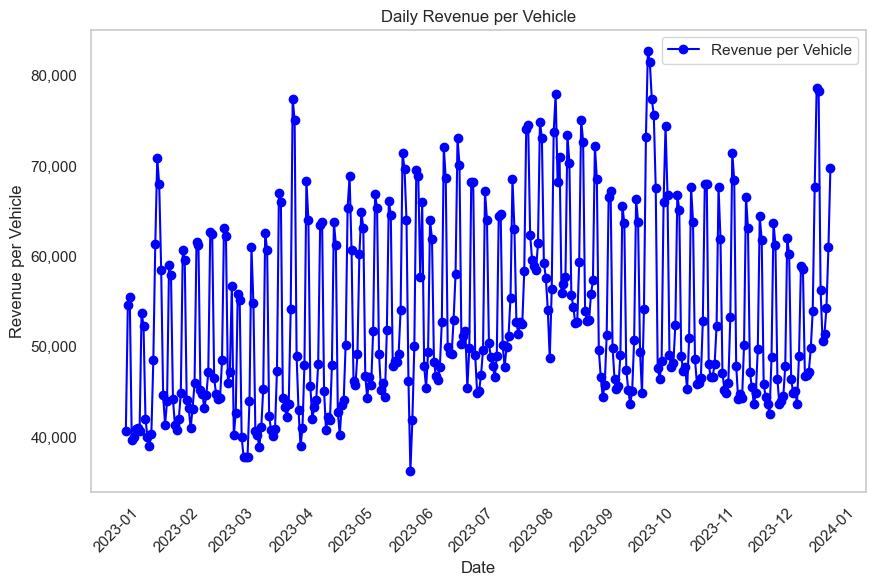

In [4]:
#plot revenue per vehicle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

# Set the style
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(daily_summary['date'], daily_summary['revenue_per_vehicle'], marker='o', color='blue', label='Revenue per Vehicle')
plt.title('Daily Revenue per Vehicle')
plt.xlabel('Date')
plt.ylabel('Revenue per Vehicle')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.grid()
plt.legend()

In [5]:
# 1) 연간·일간 성장률 정의
annual_growth = 0.0395 * 4            # 연간 성장률 (예: 0.158)
daily_growth  = annual_growth / 365   # 일간 성장률

# 2) 기준일(가장 이른 날짜) 찾기
start_date = daily_summary['date'].min()

# 3) 기준일로부터 경과 일수 계산
daily_summary['days_since_start'] = (
    daily_summary['date'] - start_date
).dt.days

# 4) 누적 성장 요인 계산
daily_summary['growth_factor'] = (
    (1 + daily_growth) ** daily_summary['days_since_start']
)

# 5) 성장 보정된 매출 컬럼 추가
#    - total_revenue 기준
daily_summary['detrended_total_revenue'] = (
    daily_summary['total_revenue'] / daily_summary['growth_factor']
)
#    - 대당매출 기준
daily_summary['detrended_rev_per_vehicle'] = (
    daily_summary['revenue_per_vehicle'] / daily_summary['growth_factor']
)

# 결과 확인
print(daily_summary[
    ['date', 'total_revenue', 'detrended_total_revenue',
     'revenue_per_vehicle', 'detrended_rev_per_vehicle']
].head())

        date  total_revenue  detrended_total_revenue  revenue_per_vehicle  \
0 2023-01-06   4.384192e+07             4.384192e+07         40631.990778   
1 2023-01-07   6.870620e+07             6.867648e+07         54528.734034   
2 2023-01-08   6.838400e+07             6.832484e+07         55416.535427   
3 2023-01-09   4.091286e+07             4.085978e+07         39605.868377   
4 2023-01-10   4.062744e+07             4.055717e+07         39987.637697   

   detrended_rev_per_vehicle  
0               40631.990778  
1               54505.140029  
2               55368.589506  
3               39554.479499  
4               39918.473693  


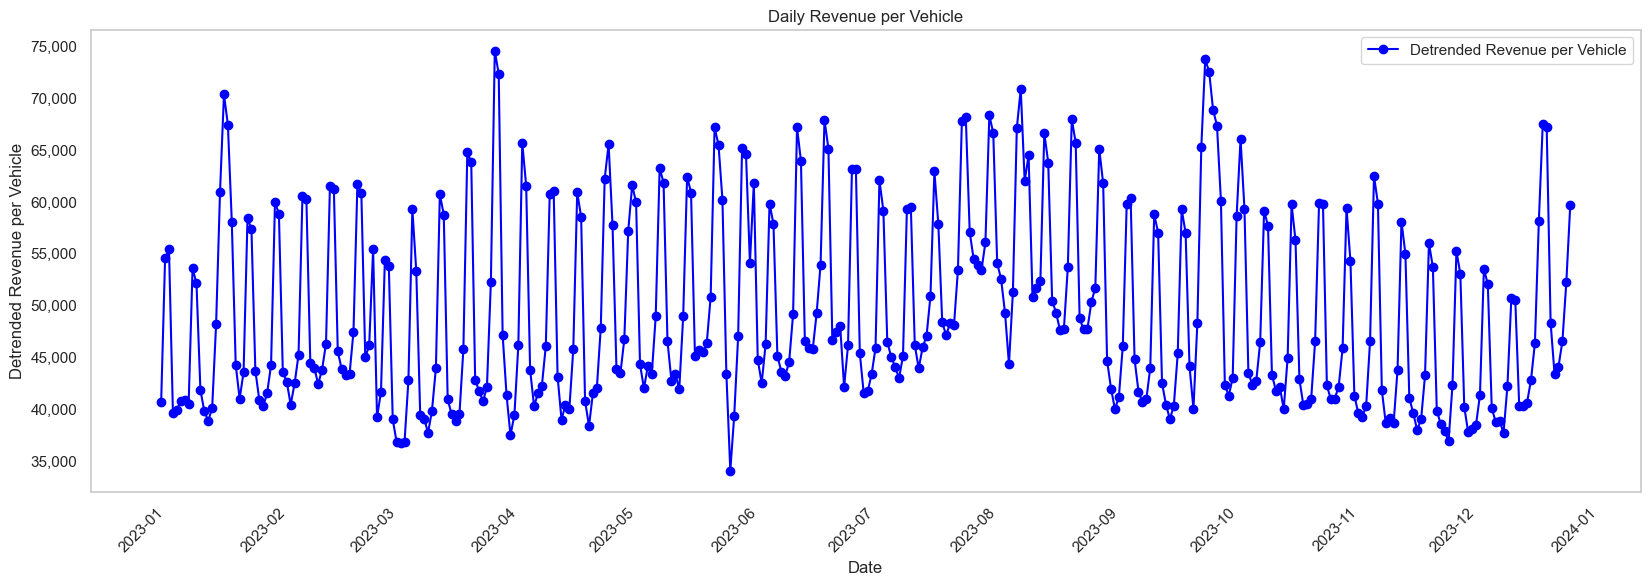

In [6]:
#plot revenue per vehicle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

# Set the style
sns.set(style="whitegrid")
plt.figure(figsize=(20, 6))
plt.plot(daily_summary['date'], daily_summary['detrended_rev_per_vehicle'], marker='o', color='blue', label='Detrended Revenue per Vehicle')
plt.title('Daily Revenue per Vehicle')
plt.xlabel('Date')
plt.ylabel('Detrended Revenue per Vehicle')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.grid()
plt.legend()

In [7]:
df_holidays = pd.read_feather('data/2023~2025년_휴일_데이터_38rows.feather')
df_holidays = df_holidays.rename(columns={'일자':'date', '휴일명':'holiday_name'})
# 가정: df_holidays에 'date' 컬럼으로 모든 공휴일 날짜가 들어있습니다.
df_holidays['date'] = pd.to_datetime(df_holidays['date'])

# 1) 요일, 주말, 공휴일, 휴일 여부 플래그
daily_summary['weekday']    = daily_summary['date'].dt.weekday
daily_summary['is_weekend'] = daily_summary['weekday'] >= 5
daily_summary['is_holiday'] = daily_summary['date'].isin(df_holidays['date'])
daily_summary['is_offday']  = daily_summary['is_weekend'] | daily_summary['is_holiday']

# 2) 연속 블록 식별 (on→off, off→on 바뀔 때마다 block_id 증가)
daily_summary['block_id'] = (
    daily_summary['is_offday'] != daily_summary['is_offday'].shift(1)
).cumsum()

# 3) 블록별 offday 총합 계산
daily_summary['offday_run'] = daily_summary.groupby('block_id')['is_offday'] \
                                         .transform('sum')

# 4) on-day(row가 offday가 아닐 때)는 0으로 초기화
daily_summary['offday_run'] = daily_summary['offday_run'].where(
    daily_summary['is_offday'], 0
)

# 5) 중간 계산용 컬럼 정리
daily_summary = daily_summary.drop(
    columns=['is_weekend','block_id']
)

# 결과 확인
print(daily_summary.head())


        date  total_revenue  vehicle_count  revenue_per_vehicle  \
0 2023-01-06   4.384192e+07           1079         40631.990778   
1 2023-01-07   6.870620e+07           1260         54528.734034   
2 2023-01-08   6.838400e+07           1234         55416.535427   
3 2023-01-09   4.091286e+07           1033         39605.868377   
4 2023-01-10   4.062744e+07           1016         39987.637697   

   days_since_start  growth_factor  detrended_total_revenue  \
0                 0       1.000000             4.384192e+07   
1                 1       1.000433             6.867648e+07   
2                 2       1.000866             6.832484e+07   
3                 3       1.001299             4.085978e+07   
4                 4       1.001733             4.055717e+07   

   detrended_rev_per_vehicle  weekday  is_holiday  is_offday  offday_run  
0               40631.990778        4       False      False           0  
1               54505.140029        5       False       True        

c:\Users\PPC-NB-\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
09:54:35 - cmdstanpy - INFO - Chain [1] start processing
09:54:37 - cmdstanpy - INFO - Chain [1] done processing


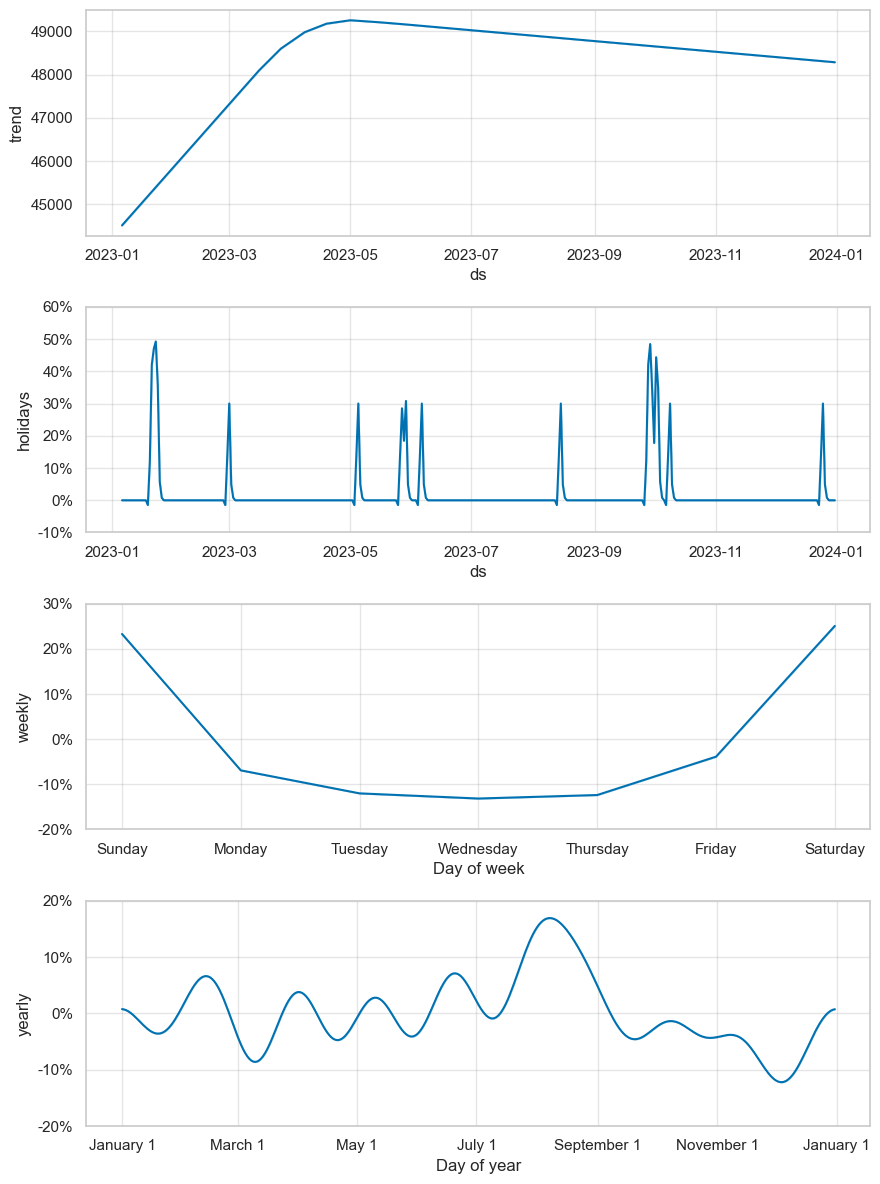

In [8]:
from prophet import Prophet
import pandas as pd

# 1) Prophet 포맷으로 컬럼 이름 변경
df_prophet = daily_summary.rename(
    columns={'date': 'ds', 'detrended_rev_per_vehicle': 'y'}
)[['ds', 'y', 'is_holiday']].copy()

# 2) holidays DataFrame 생성 (전후 3일 window)
holidays = pd.DataFrame({
    'holiday': 'custom_holiday',
    'ds':      df_prophet.loc[df_prophet['is_holiday'], 'ds'],
    'lower_window': -2,  # 휴일 3일 전부터
    'upper_window':  2   # 휴일 3일 후까지
})

# 3) Prophet 모델 정의 (추세·계절성은 기본 사용)
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=holidays,
    seasonality_mode='multiplicative'
)

# (선택) 요일 더미나 기타 회귀변수 추가하려면 아래처럼
# df_prophet['weekday'] = df_prophet['ds'].dt.weekday
# for d in range(7):
#     df_prophet[f'dow_{d}'] = (df_prophet['weekday']==d).astype(int)
# m.add_regressor('dow_0'); … 등

# 4) 모델 학습
m.fit(df_prophet[['ds', 'y']])

# 5) 미래 프레임(여기서는 과거 데이터만 분석하므로 periods=0)
future = m.make_future_dataframe(periods=0)

# 6) 예측
forecast = m.predict(future)

# 7) 휴일 효과 컴포넌트 플롯
fig = m.plot_components(forecast)

In [33]:
from prophet.serialize import model_to_json

# assuming your fitted model is `m`
with open('data/prophet_model.json', 'w') as f:
    f.write(model_to_json(m))

In [9]:
week = pd.date_range(start='2025-01-05', periods=7, freq='D')  # 기준이 되는 아무 주간이면 OK
df_week = pd.DataFrame({'ds': week})
df_week['weekday'] = df_week['ds'].dt.weekday

# 2) Prophet의 seasonal components (multiplicative 모드이므로 factor-1 형태)
seasonal = m.predict_seasonal_components(df_week)

# 3) weekly component → multiplier
df_week['weekly_multiplier'] = seasonal['weekly'] + 1

# 4) 결과 확인
print(df_week[['weekday', 'weekly_multiplier']])

   weekday  weekly_multiplier
0        6           1.232985
1        0           0.930774
2        1           0.879771
3        2           0.868360
4        3           0.876122
5        4           0.961106
6        5           1.250882


In [10]:
df_week['ds']

0   2025-01-05
1   2025-01-06
2   2025-01-07
3   2025-01-08
4   2025-01-09
5   2025-01-10
6   2025-01-11
Name: ds, dtype: datetime64[ns]

In [11]:
import pandas as pd
import statsmodels.formula.api as smf

# 0) 이미 daily_summary에 아래 칼럼들이 있다고 가정
#    - date
#    - detrended_rev_per_vehicle   (종속변수)
#    - offday_run                  (휴일 연속 길이)
#    - weekday_name                (e.g. 'Monday', 'Tuesday', ...)

# 1) Prophet에서 뽑은 요일별 multiplier 매핑 예시
prophet_weekly = df_week.set_index('weekday')['weekly_multiplier'].to_dict()
daily_summary['weekday_factor'] = daily_summary['weekday'] \
                                    .map(prophet_weekly)

# 2) offday_run 기준 holiday_factor 정의
def holiday_mult(run_length):
    if run_length >= 3:
        return 1.50
    elif run_length >= 1:
        return 1.30
    else:
        return 1.00

daily_summary['holiday_factor'] = (
    daily_summary['offday_run']
    .apply(holiday_mult)
)

# 3) interaction term을 formula에 포함시키기
#    weekday_factor 와 holiday_factor 의 곱을 자동으로 만들어 줍니다.
model = smf.ols(
    'detrended_rev_per_vehicle ~ weekday_factor * holiday_factor',
    data=daily_summary
).fit()

print(model.summary())


                                OLS Regression Results                               
Dep. Variable:     detrended_rev_per_vehicle   R-squared:                       0.785
Model:                                   OLS   Adj. R-squared:                  0.783
Method:                        Least Squares   F-statistic:                     432.9
Date:                       Thu, 15 May 2025   Prob (F-statistic):          2.23e-118
Time:                               09:54:42   Log-Likelihood:                -3525.3
No. Observations:                        360   AIC:                             7059.
Df Residuals:                            356   BIC:                             7074.
Df Model:                                  3                                         
Covariance Type:                   nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

In [12]:
# 1) 로그 변환
df = daily_summary.copy()
df['ln_rev']     = np.log(df['detrended_rev_per_vehicle'])
df['ln_weekday'] = np.log(df['weekday_factor'])
df['ln_holiday'] = np.log(df['holiday_factor'])


# 2) 로그-로그 회귀 (interaction 포함)
model_log = smf.ols(
    'ln_rev ~ ln_weekday * ln_holiday',
    data=df
).fit()

print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:                 ln_rev   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     414.7
Date:                Thu, 15 May 2025   Prob (F-statistic):          8.74e-116
Time:                        09:54:43   Log-Likelihood:                 373.36
No. Observations:                 360   AIC:                            -738.7
Df Residuals:                     356   BIC:                            -723.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                10.76

## 탄력성 예시 계산

1. **비휴일 (H = 1, \(\ln H = 0\))**  
   \[
   $\frac{\partial \ln Y}{\partial \ln W}
   = \beta_{1} + \beta_{3}\cdot0
   = 0.8301
   \quad\Longrightarrow\quad
   W\uparrow1\%\;\Rightarrow\;Y\uparrow0.83\%$
   \]

2. **짧은 휴일 (H = 1.3, \(\ln H \approx 0.262\))**  
   \[
   $\frac{\partial \ln Y}{\partial \ln W}
   = 0.8301 + (-2.2386)\times0.262
   \approx 0.244
   \quad\Longrightarrow\quad
   W\uparrow1\%\;\Rightarrow\;Y\uparrow0.24\%$
   \]
   → 휴일이 되면 요일효과의 민감도가 크게 줄어듭니다.

3. **긴 연휴 (H = 1.5, \(\ln H \approx 0.405\))**  
   \[
   $\frac{\partial \ln Y}{\partial \ln W}
   = 0.8301 + (-2.2386)\times0.405
   \approx -0.077
   \quad\Longrightarrow\quad
   W\uparrow1\%\;\Rightarrow\;Y\downarrow0.08\%$
   \]
   → 연휴가 길어질수록 요일효과가 더 상쇄되어, 요일 변화에 따른 매출 변화가 미미해지거나 약간 감소합니다.

마찬가지로 **휴일 요인에 대한 탄력성**은  
\[
$\frac{\partial \ln Y}{\partial \ln H}
= \beta_{2} + \beta_{3}\ln W$
\]
로 계산할 수 있어, 평일·주말마다 휴일 길이 민감도가 다르게 나타납니다.

---

## 모델 요약

- **\(R^2 = 0.778\)**: 관측치 변동의 약 78% 설명  
- **모든 계수 p-value < 0.001**: 통계적으로 유의미  
- **Durbin–Watson ≈ 0.44**: 잔차에 양(+)의 자기상관이 남아 있어, 시계열 특성을 추가 모델링할 여지가 있음


In [13]:
b0, bW, bH, bWH = (
    model_log.params['Intercept'],
    model_log.params['ln_weekday'],
    model_log.params['ln_holiday'],
    model_log.params['ln_weekday:ln_holiday']
)
print(f"b0: {b0}, bW: {bW}, bH: {bH}, bWH: {bWH}")

b0: 10.768002710229437, bW: 0.8301041162161154, bH: 0.7308888912495246, bWH: -2.2386432524278383


In [14]:
def day_factor(weekday_factor, holiday_factor):
    """
    Args:
      weekday_factor: Prophet으로 뽑은 요일별 multiplier (e.g. 1.23)
      holiday_factor: 휴일길이 기준 multiplier (e.g. 1.3 or 1.5)
    Returns:
      예측 대당 매출(detrended_rev_per_vehicle)
    """
    lnW = np.log(weekday_factor)
    lnH = np.log(holiday_factor)
    lnY = b0 + bW * lnW + bH * lnH + bWH * lnW * lnH
    return lnY

In [15]:
# 2) daily_summary 에 예측값 컬럼 추가
daily_summary['ln_day_factor'] = daily_summary.apply(
    lambda r: day_factor(r['weekday_factor'], r['holiday_factor']),
    axis=1
)
daily_summary['day_factor'] = np.exp(
    daily_summary['ln_day_factor']
)

# 3) 결과 확인
print(daily_summary[
    ['date', 'weekday_factor', 'holiday_factor',
     'ln_day_factor', 'day_factor','detrended_rev_per_vehicle']
].head())

        date  weekday_factor  holiday_factor  ln_day_factor    day_factor  \
0 2023-01-06        0.961106             1.0      10.735072  45939.090895   
1 2023-01-07        1.250882             1.3      11.014104  60724.611513   
2 2023-01-08        1.232985             1.3      11.010606  60512.536173   
3 2023-01-09        0.930774             1.0      10.708452  44732.356500   
4 2023-01-10        0.879771             1.0      10.661671  42687.927729   

   detrended_rev_per_vehicle  
0               40631.990778  
1               54505.140029  
2               55368.589506  
3               39554.479499  
4               39918.473693  


d:\Project\day_factor_module.py:65: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  run = int(cal.loc[cal['date'] == date, 'offday_run'])
d:\Project\day_factor_module.py:65: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  run = int(cal.loc[cal['date'] == date, 'offday_run'])
d:\Project\day_factor_module.py:65: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  run = int(cal.loc[cal['date'] == date, 'offday_run'])
d:\Project\day_factor_module.py:65: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  run = int(cal.loc[cal['date'] == date, 'offday_run'])
d:\Project\day_factor_module.py:65: FutureWarning: Calling int on a single e

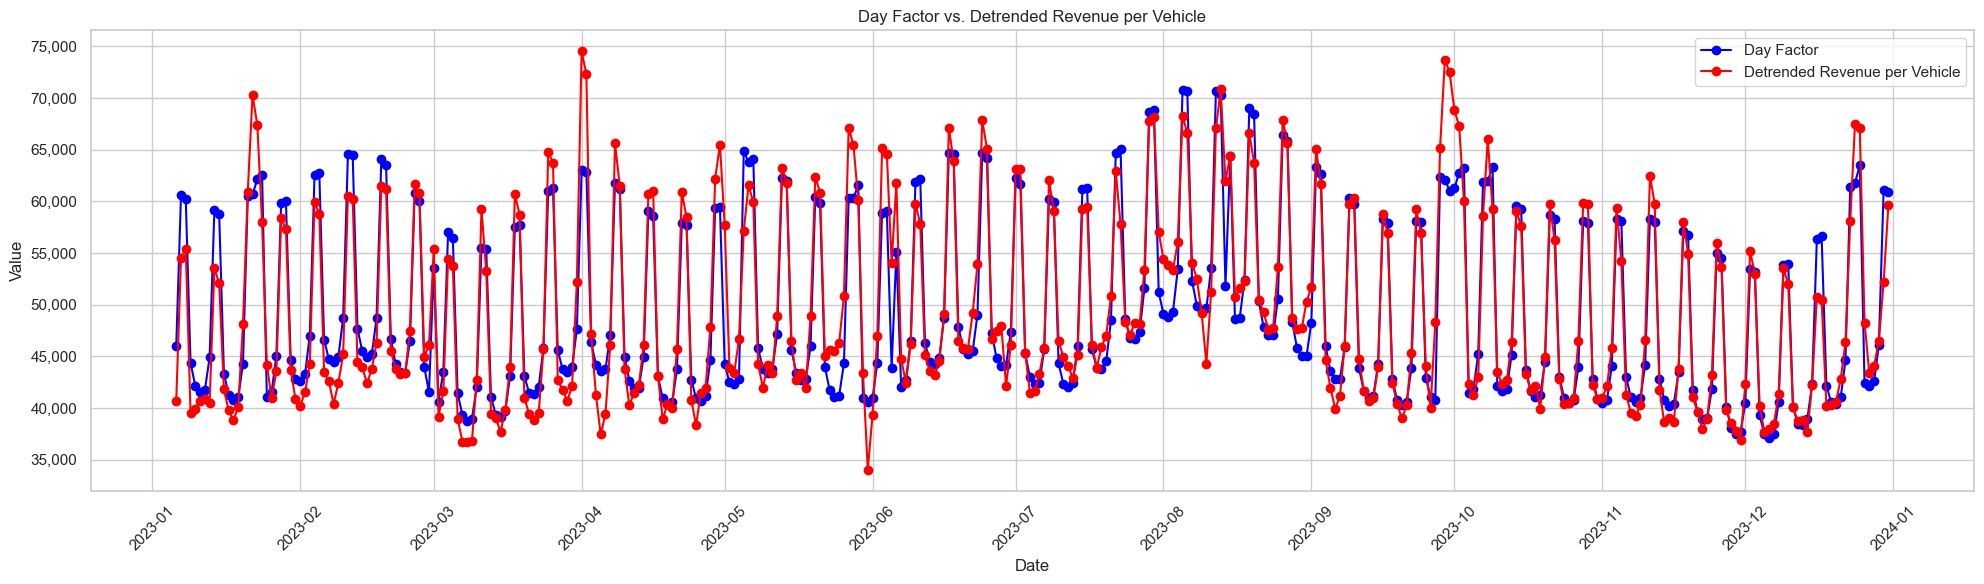

In [ ]:
import importlib
importlib.reload(day_factor_module)
# 1) Compute day_factor for each date
daily_summary['day_factor'] = daily_summary['date'].apply(day_factor_module.get_day_factor)

# 2) Plot
plt.figure(figsize=(20, 6))
plt.plot(
    daily_summary['date'],
    daily_summary['day_factor'],
    marker='o', color='blue', label='Day Factor'
)
plt.plot(
    daily_summary['date'],
    daily_summary['detrended_rev_per_vehicle'],
    marker='o', color='red', label='Detrended Revenue per Vehicle'
)
plt.title('Day Factor vs. Detrended Revenue per Vehicle')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


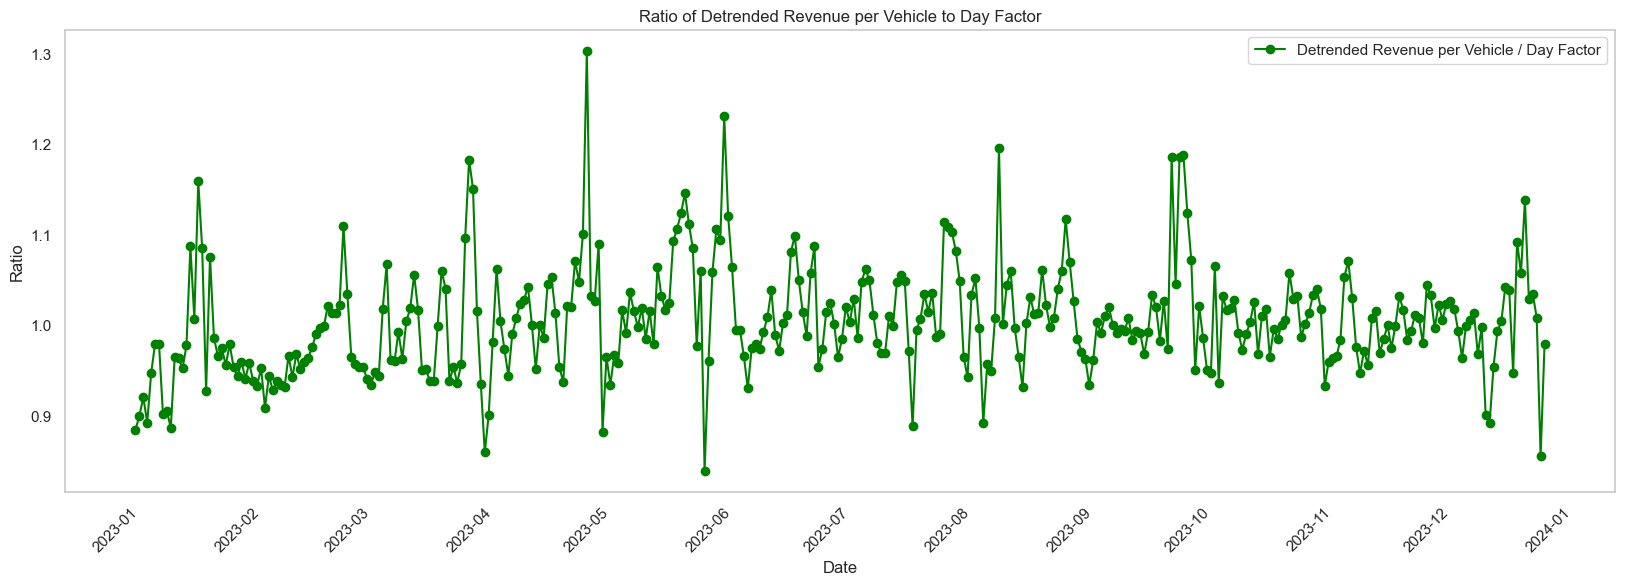

In [36]:
# Calculate the ratio
daily_summary['ratio'] = daily_summary['detrended_rev_per_vehicle'] / daily_summary['day_factor']

# Plot the ratio
plt.figure(figsize=(20, 6))
plt.plot(daily_summary['date'], daily_summary['ratio'], marker='o', color='green', label='Detrended Revenue per Vehicle / Day Factor')
plt.title('Ratio of Detrended Revenue per Vehicle to Day Factor')
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.grid()
plt.legend()
plt.show()

In [18]:
from tqdm import tqdm
import time
import importlib
importlib.reload(weatherReturn)

weather_scores = []
dates = daily_summary['date'].dt.strftime('%Y%m%d').tolist()

for d in tqdm(dates, desc='Weather scores'):
    score=weatherReturn.get_weather_score_from_csv(d)
    weather_scores.append(score)

daily_summary['weather_score'] = weather_scores


Weather scores: 100%|██████████| 360/360 [00:00<00:00, 981.29it/s] 


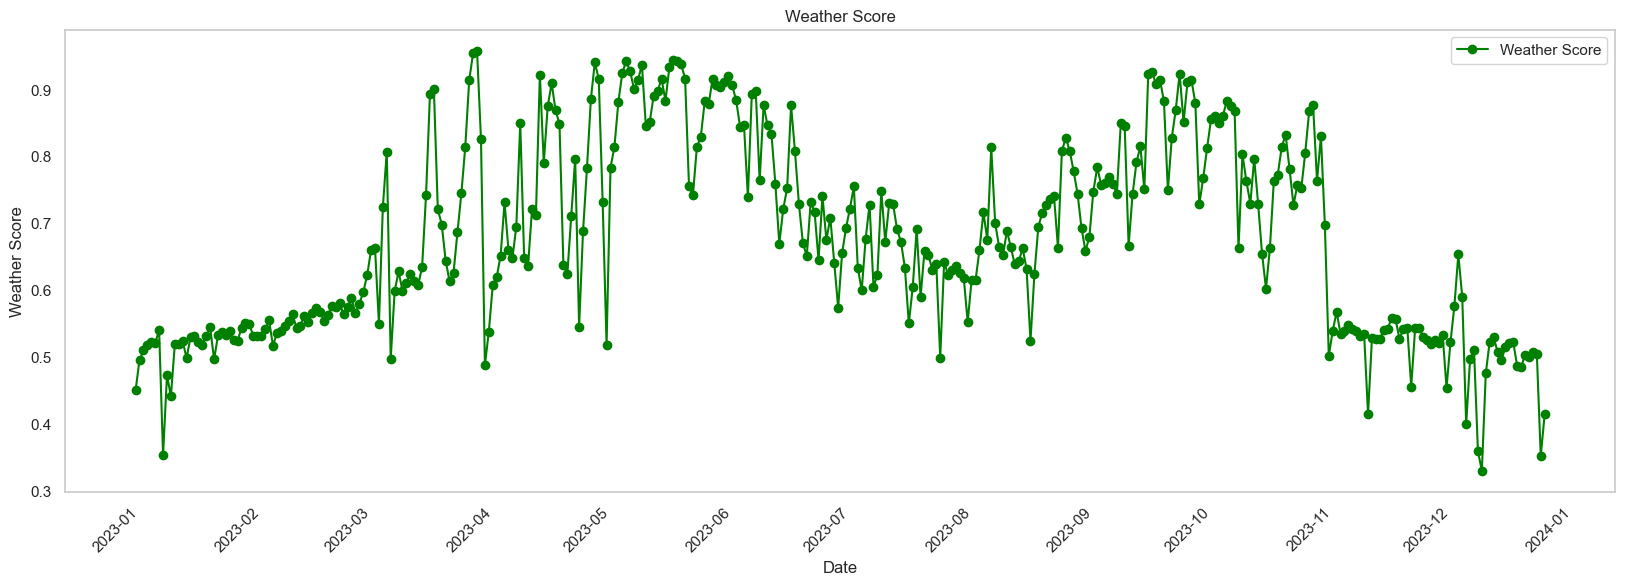

In [19]:
# plot weather score
plt.figure(figsize=(20, 6))
plt.plot(daily_summary['date'], daily_summary['weather_score'], marker='o', color='green', label='Weather Score')
plt.title('Weather Score')
plt.xlabel('Date')
plt.ylabel('Weather Score')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.1f}'))
plt.grid()
plt.legend()

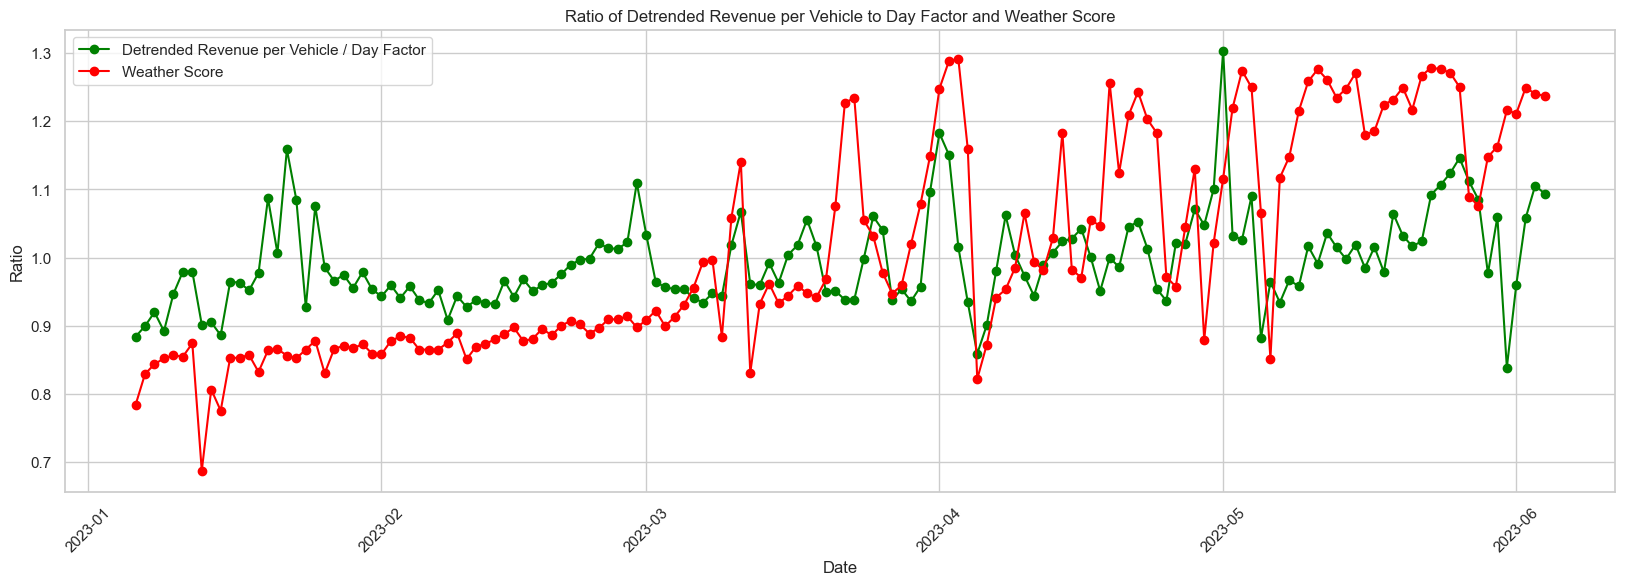

In [37]:
# Plot the ratio
plt.figure(figsize=(20, 6))
plt.plot(daily_summary['date'][:150], daily_summary['ratio'][:150], marker='o', color='green', label='Detrended Revenue per Vehicle / Day Factor')
plt.plot(daily_summary['date'][:150], (daily_summary['weather_score']+daily_summary['ratio'][0]-daily_summary['weather_score'][0]-0.1)[:150], marker='o', color='red', label='Weather Score')
plt.title('Ratio of Detrended Revenue per Vehicle to Day Factor and Weather Score')
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.legend()
plt.show()

Pearson correlation between precipitation and revenue_per_vehicle: -0.035


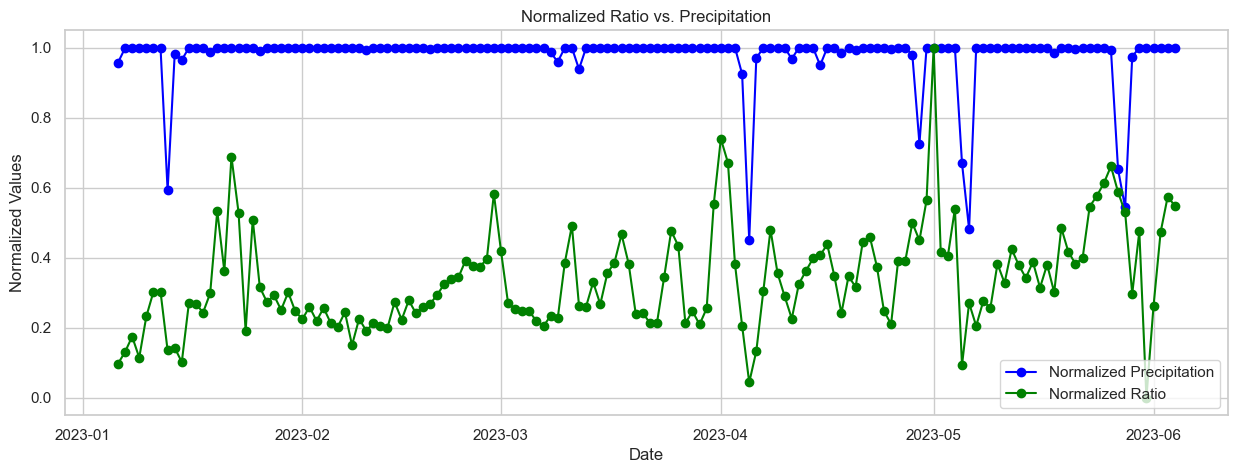

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load your daily revenue summary
#    (assuming you’ve already got daily_summary in your notebook)
#    daily_summary has columns: date (datetime), revenue_per_vehicle (float)
# daily_summary = pd.read_csv('…')  # or however you already have it

# 2. Load the weather CSV you saved
weather = pd.read_csv(
    'data/weather/weather_2023.csv',
    parse_dates=['date'],
    dtype={'P': float}
)

# 3. Keep only date and precipitation
weather = weather[['date', 'P']].rename(columns={'P': 'precipitation'})

# 4. Merge on date
df = pd.merge(
    daily_summary,
    weather,
    on='date',
    how='left'
)

# 5. Drop days with no precipitation data (if any)
df = df.dropna(subset=['precipitation'])

# 6. Compute correlation
corr = df['precipitation'].corr(df['detrended_rev_per_vehicle'])
print(f"Pearson correlation between precipitation and revenue_per_vehicle: {corr:.3f}")

# 7. Scatter plot
# Normalize precipitation and ratio
df['normalized_precipitation'] = (df['precipitation'] - df['precipitation'].min()) / (df['precipitation'].max() - df['precipitation'].min())
df['normalized_ratio'] = (df['ratio'] - df['ratio'].min()) / (df['ratio'].max() - df['ratio'].min())

# Scatter plot with normalized values
plt.figure(figsize=(15, 5))
plt.plot(df['date'][:150], 1-df['normalized_precipitation'][:150], marker='o', color='blue', label='Normalized Precipitation')
plt.plot(df['date'][:150], df['normalized_ratio'][:150], marker='o', color='green', label='Normalized Ratio')
plt.xlabel('Date')
plt.ylabel('Normalized Values')
plt.title('Normalized Ratio vs. Precipitation')
plt.grid(True)
plt.legend()
plt.show()